Refer here for instructions to [download and run this sample locally](https://developers.arcgis.com/python/sample-notebooks/#Download-and-run-the-sample-notebooks) on your computer

# Clone Portal users, groups and content

This sample notebook can be used for cloning an entire Portal, from maybe a staging to a production environment. It clones the users, groups and the content. It does not copy over services and data though, and works at the tier of Portal items.

In [1]:
from arcgis import GIS
from IPython.display import display

## Define the source and target portals
To start with, define the source and target portals. Connect to them using accounts with administrative privileges:

In [2]:
source = GIS("portal or org url", "username", "password")
target = GIS("portal or org url", "username", "password")
target_admin_username = 'admin'

# Users
List the users in the source and target portals:

In [3]:
sourceusers = source.users.search()
sourceusers

[<User username:admin>,
 <User username:demo_account>,
 <User username:esri_boundaries>,
 <User username:esri_demographics>,
 <User username:esri_livingatlas>,
 <User username:esri_nav>,
 <User username:imagery>,
 <User username:journalist>,
 <User username:social>,
 <User username:system_publisher>,
 <User username:urban_planning>,
 <User username:weather>]

In [4]:
targetusers = target.users.search()
targetusers

[<User username:admin>,
 <User username:esri_boundaries>,
 <User username:esri_demographics>,
 <User username:esri_livingatlas>,
 <User username:esri_nav>,
 <User username:system_publisher>]

If source users are already in the target, run the following code to delete them:

In [5]:
# create a list of system accounts that should not be modified
systemusers = ['system_publisher', 'esri_nav', 'esri_livingatlas', 
               'esri_boundaries', 'esri_demographics']

### Remove existing users from target portal
Assign their content to admin account and delete the account

In [6]:
for srcuser in sourceusers:
    if not srcuser.username in systemusers:
        if srcuser.username is not target_admin_username: #don't delete the account used to connect
            try:
                targetusr = target.users.get(srcuser.username)
                if targetusr is not None:
                    print('Deleting user: ' + targetusr.fullname)
                    targetusr.reassign_to(target_admin_username)
                    targetusr.delete()
            except:
                print('User {} does not exist in Target Portal'.format(srcuser.username))

User does not exist or is inaccessible.


User admin does not exist in Target Portal
User demo_account does not exist in Target Portal


User does not exist or is inaccessible.


User imagery does not exist in Target Portal


User does not exist or is inaccessible.
User does not exist or is inaccessible.


User journalist does not exist in Target Portal
User social does not exist in Target Portal


User does not exist or is inaccessible.


User urban_planning does not exist in Target Portal


User does not exist or is inaccessible.


User weather does not exist in Target Portal


### Copy Users
Create a function that will accept connection to the target portal, user objects and password to create users with.

In [7]:
def copy_user(target, user, password):
    # See if the user has firstName and lastName properties
    try:
        firstname = user.firstName
        lastname = user.lastName
    except:
        # if not, split the fullName
        fullName = user.fullName
        firstname = fullName.split()[0]
        try:
            lastname = fullName.split()[1]
        except:
            lastname = 'NoLastName'

    try:
        # create user
        target_user = target.users.create(user.username, password, firstname, lastname,
                                          user.email, user.description, user.role)

        # update user properties
        target_user.update(user.access, user.preferredView,
                           user.description, user.tags, user.get_thumbnail_link(),
                           culture=user.culture, region=user.region)
        return target_user
    
    except:
        print("Unable to create user "+ user.username)
        return None

For each user in source portal, make a corresponding user in target portal:

In [8]:
ignore_list = [target_admin_username,'system_publisher', 'esri_nav', 'esri_livingatlas', 
               'esri_boundaries', 'esri_demographics']
for user in sourceusers:
    if not user.username in ignore_list:
        print("Creating user: " + user.username)
        copy_user(target, user, 'TestPassword@123')

Creating user: demo_account
Creating user: imagery
Creating user: journalist
Creating user: social
Creating user: urban_planning
Creating user: weather


Verify that users have been added to target portal:

In [9]:
targetusers = target.users.search()
targetusers

[<User username:admin>,
 <User username:demo_account>,
 <User username:esri_boundaries>,
 <User username:esri_demographics>,
 <User username:esri_livingatlas>,
 <User username:esri_nav>,
 <User username:imagery>,
 <User username:journalist>,
 <User username:social>,
 <User username:system_publisher>,
 <User username:urban_planning>,
 <User username:weather>]

Thus users have been successfully added to the target portal

# Groups

List the groups in the source and target portals:

In [10]:
sourcegroups = source.groups.search()
sourcegroups

[<Group title:"Basemaps" owner:admin>,
 <Group title:"Central Services" owner:admin>,
 <Group title:"Compliance" owner:admin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>,
 <Group title:"Demographic Content" owner:admin>,
 <Group title:"Design and Engineering" owner:admin>,
 <Group title:"Disaster Response" owner:admin>,
 <Group title:"Esri Boundary Layers" owner:esri_boundaries>,
 <Group title:"Esri Demographic Layers" owner:esri_demographics>,
 <Group title:"Executive Reports" owner:admin>,
 <Group title:"External Contractors" owner:admin>,
 <Group title:"Featured Apps" owner:admin>,
 <Group title:"Featured Maps and Apps" owner:admin>,
 <Group title:"Field and Facility Maintenance" owner:admin>,
 <Group title:"Fire Service" owner:admin>,
 <Group title:"Gallery" owner:admin>,
 <Group title:"Industrial Monitoring" owner:admin>,
 <Group title:"Lab Services" owner:admin>,
 <Group title:"Land Use Content" owner:admin>,
 <Group title:"Living Atlas" owner:

In [11]:
targetgroups = target.groups.search()
targetgroups

[<Group title:"Basemaps" owner:admin>,
 <Group title:"Esri Boundary Layers" owner:esri_boundaries>,
 <Group title:"Esri Demographic Layers" owner:esri_demographics>,
 <Group title:"Living Atlas" owner:esri_livingatlas>,
 <Group title:"Living Atlas Analysis Layers" owner:esri_livingatlas>,
 <Group title:"Navigator Maps" owner:esri_nav>]

If source groups are already in the target, run the following code to delete them. If the group belongs to any of built-in user accounts, don't delete it.

In [12]:
groups_to_ignore = ['Basemaps']
for tg in targetgroups:
    if tg.title not in groups_to_ignore:
        for sg in sourcegroups:
            if sg.title == tg.title and (not tg.owner in systemusers):
                print("Cleaning up group {} in target Portal...".format(tg.title))
                tg.delete()
                break

## Copy Groups

In [13]:
import tempfile

GROUP_COPY_PROPERTIES = ['title', 'description', 'tags', 'snippet', 'phone',
                         'access', 'isInvitationOnly']

def copy_group(target, source, group):
    """ Copy group to the target portal."""
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create new groups with the subset of properties we want to
        # copy to the target portal. Handle switching between org and
        # public access when going from an org in a multitenant portal
        # and a single tenant portal
        target_group = {}
        
        for property_name in GROUP_COPY_PROPERTIES:
            target_group[property_name] = group[property_name]

        if target_group['access'] == 'org' and target.properties['portalMode'] == 'singletenant':
            target_group['access'] = 'public'
        elif target_group['access'] == 'public'\
             and source.properties['portalMode'] == 'singletenant'\
             and target.properties['portalMode'] == 'multitenant'\
             and 'id' in target.properties: # is org
            target_group['access'] = 'org'

        # Handle the thumbnail (if one exists)
        thumbnail_file = None
        if 'thumbnail' in group:
            target_group['thumbnail'] = group.download_thumbnail(temp_dir)

        # Create the group in the target portal
        copied_group = target.groups.create_from_dict(target_group)
        
         # Reassign all groups to correct owners, add users, and find shared items
        members = group.get_members()
        if not members['owner'] == target_admin_username:
            copied_group.reassign_to(members['owner'])
        if members['users']:
            copied_group.add_users(members['users'])
        return copied_group

For each group in source portal, make a corresponding group in target portal and a create a dictionary of source group id and corresponding group id in target portal:

In [14]:
copied_groups = {}
for group in sourcegroups:
    if group.title not in groups_to_ignore:
        if not group.owner in systemusers:
            print("Copying group: " + group.title)
            tgt_group = copy_group(target, source, group)
            copied_groups[group.groupid] = tgt_group.groupid

Copying group: Central Services
Copying group: Compliance
Copying group: Customer Service, Finance, Billing and Accounting
Copying group: Demographic Content
Copying group: Design and Engineering
Copying group: Disaster Response
Copying group: Executive Reports
Copying group: External Contractors
Copying group: Featured Apps
Copying group: Featured Maps and Apps
Copying group: Field and Facility Maintenance
Copying group: Fire Service
Copying group: Gallery
Copying group: Industrial Monitoring
Copying group: Lab Services
Copying group: Land Use Content
Copying group: Network Operations
Copying group: Public Maps and Apps
Copying group: Tools and Add-Ins
Copying group: Wastewater Treatment
Copying group: Water Treatment
Copying group: Web App Templates


Verify that groups have been created in the target portal:

In [15]:
targetgroups = target.groups.search()
targetgroups

[<Group title:"Basemaps" owner:admin>,
 <Group title:"Central Services" owner:admin>,
 <Group title:"Compliance" owner:admin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>,
 <Group title:"Demographic Content" owner:admin>,
 <Group title:"Design and Engineering" owner:admin>,
 <Group title:"Disaster Response" owner:admin>,
 <Group title:"Esri Boundary Layers" owner:esri_boundaries>,
 <Group title:"Esri Demographic Layers" owner:esri_demographics>,
 <Group title:"Executive Reports" owner:admin>,
 <Group title:"External Contractors" owner:admin>,
 <Group title:"Featured Apps" owner:admin>,
 <Group title:"Featured Maps and Apps" owner:admin>,
 <Group title:"Field and Facility Maintenance" owner:admin>,
 <Group title:"Fire Service" owner:admin>,
 <Group title:"Gallery" owner:admin>,
 <Group title:"Industrial Monitoring" owner:admin>,
 <Group title:"Lab Services" owner:admin>,
 <Group title:"Land Use Content" owner:admin>,
 <Group title:"Living Atlas" owner:

Print the mapping of source and target group ids:

In [16]:
copied_groups

{'00685d821437479a846032c421af2e20': '35ba955e06c24448a87a0f840188f2c2',
 '03b3e9b1f1874ac4bc85f076d7371373': 'aec0c57a26e9499693229c2e8ccd8dad',
 '04abaffa97e34008a4fdaca17e804b22': '1a555adb5d744c1e878ca6039c20ffcb',
 '062dca8862854c9c8f3cd186554481b4': '54b3f0c7beb24242b61169e708b3b671',
 '0cfbd25be6904bb1a871e33248ac3686': '5bd66bb3beb844698a7db6fad533b017',
 '0f902ab159474ba98e71cc6a83c55deb': '172cd7a24d5344c1b25a9390995b5097',
 '1c498c18b4a04dc3924426f42457e8c6': '395838c51ca540bba8144373e7806858',
 '30d6efd349094523aaf118dda49c7b5a': '1d08f1ca6e29431895a4ae56b9fbcbe5',
 '382d38c360c345a2b10d6205b31d7568': 'd880d334870b4189a548e231318e525f',
 '4bd58d252e2b40f6869f7af415225b97': '668dc64743a4476cb8898a9988c5b560',
 '5e6744e9f15e428b8e3c5adc332117dc': '63bbba1742d94496ae4360972c466486',
 '77f719c3b8fc4b979798121163bd72d1': '7575576e35e249f9912e9631ac12753f',
 '7d5b72995cc844649b6ad16e34daff6d': '620a39ada91749dfb99da0a2c91c1cec',
 '856aab07012f487ea0f754db6c8de399': 'b4b38931dee64

With this part of the sample, we have successfully created users, groups and added the appropriate users to these groups.

# Items

Copying items consists of multiple steps. The following section of the sample does the following
    1. Create a dictionary of itemIds and item objects for each user in each folder
    2. Prepare sharing information for each item

## Create a dictionary of itemIds and item objects
Do this for each user and each folder in the user account

In [17]:
source_items_by_id = {}
for user in sourceusers:
    if not user.username in systemusers:  # ignore any 'system' Portal users
        print("Collecting item ids for {}...".format(user.username))
        usercontent = user.items()
        # Copy item ids from root folder first
        for item in usercontent:
            source_items_by_id[item.itemid] = item 
        # Copy item ids from folders next
        folders = user.folders
        for folder in folders:
            folderitems = user.items(folder=folder['title'])
            for item in folderitems:
                source_items_by_id[item.itemid] = item 

## Prepare sharing information for each item

In [18]:
for group in sourcegroups:
    if group.title not in groups_to_ignore:
        if not group.owner in systemusers:
            target_group_id = copied_groups[group.groupid]
            for group_item in group.content():
                if not group_item.owner in systemusers:
                    try:
                        item = source_items_by_id[group_item.itemid]
                        if item is not None:
                            if not 'groups'in item:
                                item['groups'] = []
                            item['groups'].append(target_group_id)
                    except:
                        print("Not found item : " + group_item.itemid)

### Print a mapping of item and its group membership

In [19]:
for key in source_items_by_id.keys():
    item = source_items_by_id[key]
    print("\n{:40s}".format(item.title), end = " # ")
    if 'groups' in item:
        print(item.access, end = " # ")
        print(item.groups, end = "")


hurricane_tracks_agg_result_fullds5      # 
hurricane_tracks_agg_result_fullds       # 
Austin_Map_WFL                           # shared # ['9b2ed6d7008d447b898bed8278bf6bbc']
Parcel_data                              # org # ['9b2ed6d7008d447b898bed8278bf6bbc']
ImgSrv_Iran_WorldView2_Multispectral     # 
bigDataFileShares_full_dataset2          # 
PrintingTools                            # 
Chennai_precipitation                    # 
SampleWorldCities                        # 
Austin_Map_WFL                           # 
bigDataFileShares_ht_ui2                 # 
Geometry                                 # 
bigDataFileShares_fixtry4                # 
Parcel_data                              # 
hurricane_tracks_agg_result_fullds_shp   # 
Buildings                                # shared # ['9b2ed6d7008d447b898bed8278bf6bbc']
bigDataFileShares_ht_ui5                 # 
Community_inteaction_map_WFL             # 
bigDataFileShares_full_dataset3          # 
Community_inteaction_map       

## Copy Items

In [20]:
TEXT_BASED_ITEM_TYPES = frozenset(['Web Map', 'Feature Service', 'Map Service','Web Scene',
                                   'Image Service', 'Feature Collection', 
                                   'Feature Collection Template',
                                   'Web Mapping Application', 'Mobile Application', 
                                   'Symbol Set', 'Color Set',
                                   'Windows Viewer Configuration'])
ITEM_COPY_PROPERTIES = ['title', 'type', 'typeKeywords', 'description', 'tags',
                        'snippet', 'extent', 'spatialReference', 'name',
                        'accessInformation', 'licenseInfo', 'culture', 'url', ]

def copy_item(target, owner, folder, item):
    with tempfile.TemporaryDirectory() as temp_dir:
        copy_item = {}
        for property_name in ITEM_COPY_PROPERTIES:
            copy_item[property_name] = item[property_name]

        data_file = None
        if item.type in TEXT_BASED_ITEM_TYPES:
            # If its a text-based item, then read the text and add it to the request.
            if item.size > 0:
                text = item.get_data(False)
                #textstr = text.decode('utf-8')
                copy_item['text'] = text
        elif item.size > 0: # download data for all other types, not just item.type in FILE_BASED_ITEM_TYPES:
            # download data and add to the request as a file
            data_file = item.download(temp_dir)

        thumbnail_file = item.download_thumbnail(temp_dir)

        metadata_file = item.download_metadata(temp_dir)

        # Add the item to the target portal
        copied_item = target.content.add(copy_item, data_file, thumbnail_file, 
                                         metadata_file, owner, folder)

        return copied_item

In [21]:
RELATIONSHIP_TYPES = frozenset(['Map2Service', 'WMA2Code',
                                'Map2FeatureCollection', 'MobileApp2Code', 'Service2Data',
                                'Service2Service'])

def copy_relationships(target, copied_items, src_item, relationships, owner, folder):
    
    target_item_id = copied_items.get(src_item.itemid)
    if target_item_id is not None:
        target_item = target.content.get(target_item_id)

        for rel_type in RELATIONSHIP_TYPES:
            src_rel_items = src_item.related_items(rel_type)

            for src_rel_item in src_rel_items:
                print("***Found related items for " + src_rel_item.title)
                source_rel_id = src_rel_item.itemid

                # See if it's already been copied to the target
                target_rel_id = copied_items.get(source_rel_id)
                if not target_rel_id:
                    # If not, then copy it to the target - folder may have moved though?
                    target_rel_item = clone_item(target, owner, folder, src_rel_item)

                    if target_rel_item is not None:
                        # add relationship from target_item to copied item
                        result = target_item.add_relationship(target_rel_item, rel_type)

                        if not result:
                            print('Unable to add relationship from ' +  target_item.itemid + ' to ' + target_rel_item.itemid)
                    else:
                        print("@@@Error Cloning Item "+src_rel_item.title)

**************
admin


<Item title:"SampleWorldCities" type:WMS owner:admin>

<Item title:"SampleWorldCities" type:Map Service owner:admin>

<Item title:"SampleWorldCities" type:Map Service owner:admin>

<Item title:"PrintingTools" type:Geoprocessing Service owner:admin>

<Item title:"SampleWorldCities" type:WMS owner:admin>

<Item title:"Chennai_precipitation" type:CSV owner:admin>
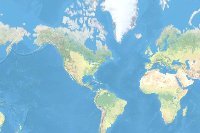

<Item title:"bigDataFileShares_Chicago_accidents" type:Big Data File Share owner:admin>

<Item title:"Geometry" type:Geometry Service owner:admin>

<Item title:"bigDataFileShares_ht_ui5" type:Big Data File Share owner:admin>

<Item title:"PrintingTools" type:Geoprocessing Service owner:admin>

<Item title:"bigDataFileShares_ht_ui3" type:Big Data File Share owner:admin>

<Item title:"Geometry" type:Geometry Service owner:admin>

<Item title:"bigDataFileShares_full_dataset2" type:Big Data File Share owner:admin>

<Item title:"bigDataFileShares_full_dataset3" type:Big Data File Share owner:admin>

<Item title:"bigDataFileShares_ht_ui2" type:Big Data File Share owner:admin>

<Item title:"hurricane_tracks_agg_result_fullds_gdb" type:File Geodatabase owner:admin>

<Item title:"hurricane_tracks_agg_result_fullds" type:Feature Service owner:admin>

<Item title:"hurricane_tracks_agg_result_fullds_shp" type:Shapefile owner:admin>

<Item title:"hurricane_tracks_agg_result" type:Feature Service owner:admin>

<Item title:"hurricane_tracks_agg_result_fullds5" type:Feature Service owner:admin>

<Item title:"bigDataFileShares_fixtry4" type:Big Data File Share owner:admin>

<Item title:"Landast Montana2015" type:Image Service owner:admin>
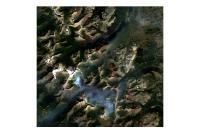

<Item title:"ImgSrv WorldView2 Multispectral" type:Image Service owner:admin>
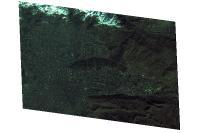

**************
demo_account
**************
imagery
**************
journalist
**************
social


<Item title:"Community_inteaction_map_WFL" type:Service Definition owner:social>
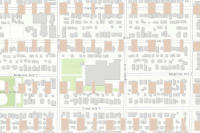

<Item title:"Community_inteaction_map_WFL" type:Feature Service owner:social>
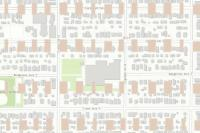

<Item title:"Community_inteaction_map" type:Web Map owner:social>
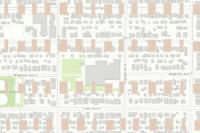

**************
urban_planning


<Item title:"Parcel_data" type:Service Definition owner:urban_planning>
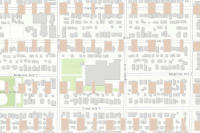

<Item title:"Austin_Map_WFL" type:Service Definition owner:urban_planning>
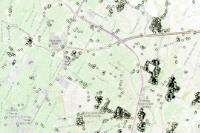

<Item title:"Austin_Map_WFL" type:Feature Service owner:urban_planning>
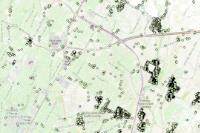

<Item title:"Parcel_data" type:Feature Service owner:urban_planning>
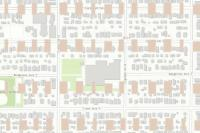

<Item title:"Buildings" type:Map Service owner:urban_planning>
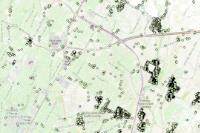

**************
weather


<Item title:"Hurricanes" type:Shapefile owner:weather>

<Item title:"earthquakes" type:Feature Service owner:weather>

<Item title:"earthquakes" type:CSV owner:weather>
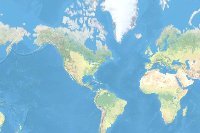

<Item title:"Hurricanes" type:Feature Service owner:weather>

In [22]:
copied_items = {}
relationships = RELATIONSHIP_TYPES

for user in sourceusers:
    if not user.username in systemusers:
        print("**************\n"+user.username)
        usercontent = user.items()
        folders = user.folders
        for item in usercontent:
            try:
                copied_item = copy_item(target, user, None, item)
                if copied_item is not None:
                    copied_items[item.itemid] = copied_item.itemid
                    # share the item
                    copied_item.share(item.access == 'public',
                                        item.access in ['org', 'public'],
                                        source_items_by_id[item.itemid].groups 
                                            if 'groups' in source_items_by_id[item.itemid]
                                            else None)
                    display(item)
                else:
                    print('Error copying ' + item.title)
            except:
                print("Error copying " + item.title)

        for folder in folders:
            target.content.create_folder(user, folder)
            folderitems = user.items(folder.title)
            for item in folderitems:
                try:
                    #display(item)
                    #print(item.__repr__())
                    copied_item = copy_item(target, user, folder.title, item)
                    if copied_item is not None:
                        copied_items[item.itemid] = copied_item.itemid

                        # share the item
                        copied_item.share(item.access == 'public',
                                          item.access in ['org', 'public'],
                                          source_items_by_id[item.itemid].groups 
                                              if 'groups' in source_items_by_id[item.itemid]
                                              else None)
                    else:
                        print('Error copying ' + item.title)
                except:
                    print("Error copying " + item.title )

        # Copy the related items for this user (if specified)
        if relationships:
            for folder in folders:
                folderitems = usercontent[folder]
                for item in folderitems:
                    try:
                        copy_relationships(target, copied_items, item, 
                                           relationships, user, folder)
                    except:
                        print("Error setting relationship for: " + item.title)
